In [7]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from pathlib import Path
from analysis import files, emg, analysis
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

root_data_path = Path("/Users/spencer/motor-control/data")
rawdata_path = root_data_path / "rawdata" 
metadata_path = root_data_path / "metadata"
experiment = "emg_olympics"
subjects = files.get_subjects("emg_olympics")
task = "center_hold"

In [8]:
from sklearn.decomposition import PCA

todo
- think about the lag from movement to on screen -- what makes this up? 
- order subjects by variance ratio mean-- can we group them? do they cluster?
- look at only the last N blocks for means-- do we get subject grouping now?


theory
- based on the variance ratio results, we think (most?) people aren't internalizing the decoder, we don't see a reduction in variance in the task space
- people aren't honing a flexible strategy because they don't seem to be "finding" the decoder
- this leads us to think that people are learning rote movements, they're not learning the decoder directly. we don't really see people honing the decoder, disregarding the null space. 

predictions / hypotheses
- what we need to do now is chase this from the other side-- is there evidence that people are using memory of rote movements to succeed in the task?
- our first check here is to look at whether we see correlations between past hits into the future-- do older trials correlate strongly with later trials? regardless of the null space?
- if we see repetition across trials in the null space, people are likely learning rote movements!



In [2]:
def load_center_hold_emg(session_path, channel=None):
    data = {}
    paths = sorted(
        [
            x
            for x in session_path.iterdir()
            if "emg" in x.name and "filtered" not in x.name and x.suffix == ".bin"
        ],
        key=files.parse_filename_prefix,
    )
    for p in paths:
        prefix = parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p, dtype=np.int32).reshape(-1, 68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_trial_emg(trial_path):
    return np.fromfile(trial_path, dtype=np.int32).reshape(-1, 68)
    
    
def parse_filename_prefix(x):
    name = x.name
    prefix = name[:2]
    if prefix[-1] == "_":
        return int(prefix[0])
    else:
        return int(prefix)

In [60]:
# concat session emg, PCA this, then look at "dynamics" of PCA over sessions

subject_explained_variance_ratios = []
for subject in subjects[:6]:
    explained_variance_ratios = []
    # sort by session number
    sorted_session_paths = sorted([x for x in (rawdata_path / experiment / subject / task).iterdir() if x.name[0] != "." and "session" in x.name], key=lambda x: int(x.name.split("_")[-1]))
    for s in sorted_session_paths[:45]:
        session = analysis.Session(s)
        signal = np.empty([0,68])
        for t in session.trials:
            # concatenate sessions
            new_signal = load_trial_emg(t.emg_path)
            signal = np.vstack((signal, new_signal))

        signal = emg.highpass(signal, cutoff=5)
        signal = emg.filter_emg(signal)
        num_components = 4
        pca_model = PCA(n_components=num_components)
        pca_model.fit(signal[:,:64])
        explained_variance_ratios.append(pca_model.explained_variance_ratio_)

    subject_explained_variance_ratios.append(np.array(explained_variance_ratios))

In [57]:
len(subject_explained_variance_ratios)

6

Text(0, 0.5, 'Variance Explained')

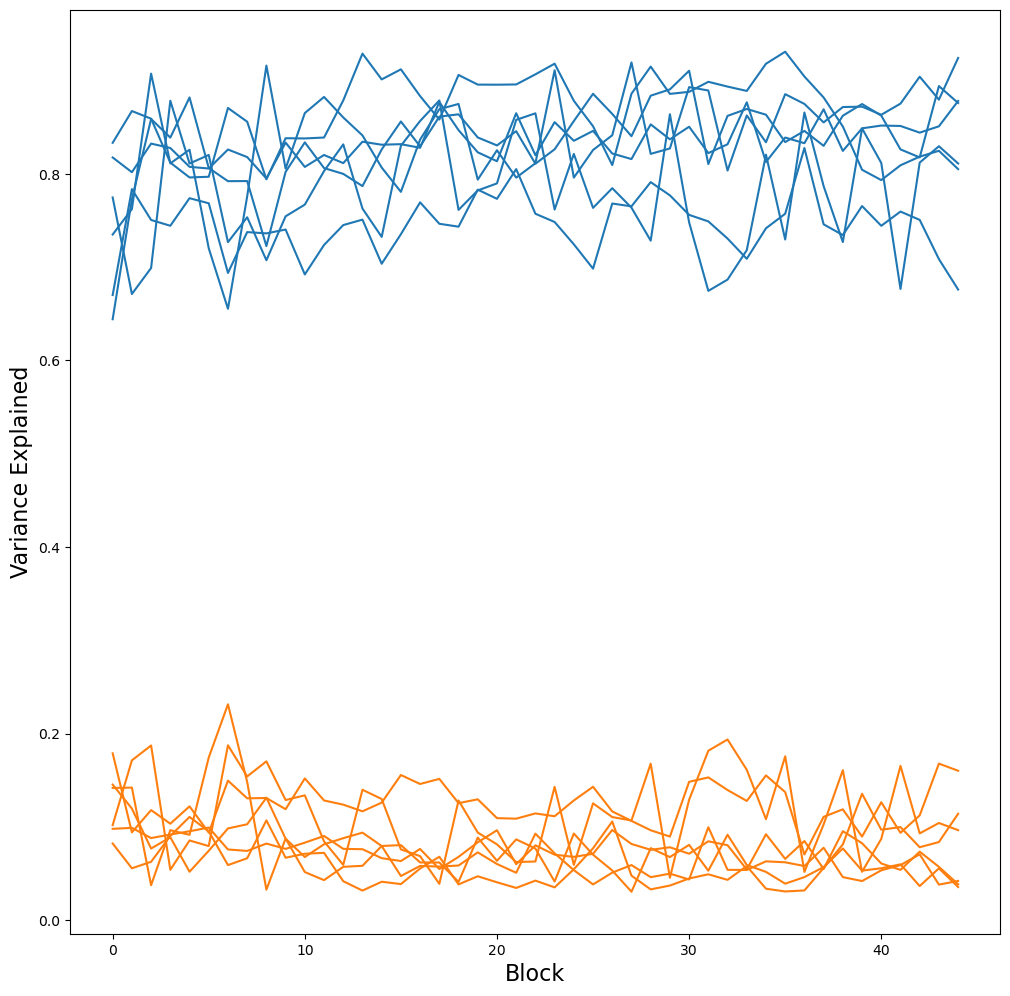

In [66]:
PCA_fig, ax = plt.subplots(1,1,figsize=(12,12))
for sevr in subject_explained_variance_ratios:
    for c, evr in zip(["tab:blue","tab:orange"], sevr.T[:2]):
        ax.plot(evr,c=c)
ax.set_xlabel("Block", fontsize=16)
ax.set_ylabel("Variance Explained", fontsize=16)

In [67]:
PCA_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/PCA_blocks.pdf", dpi=300, format="pdf")

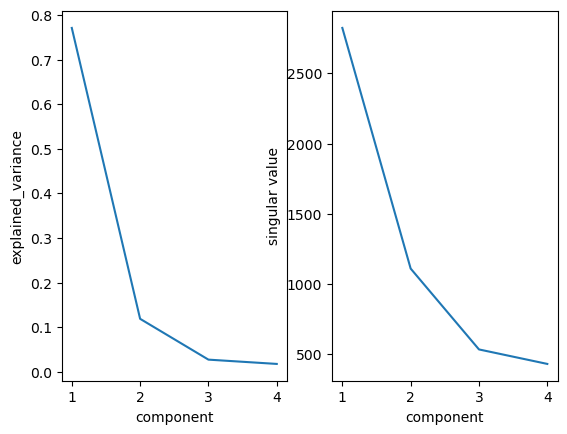

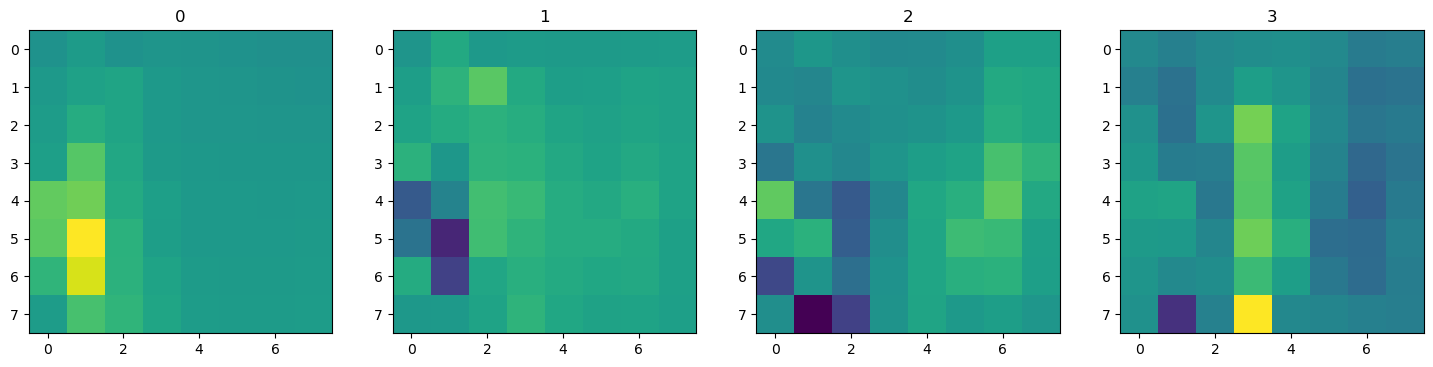

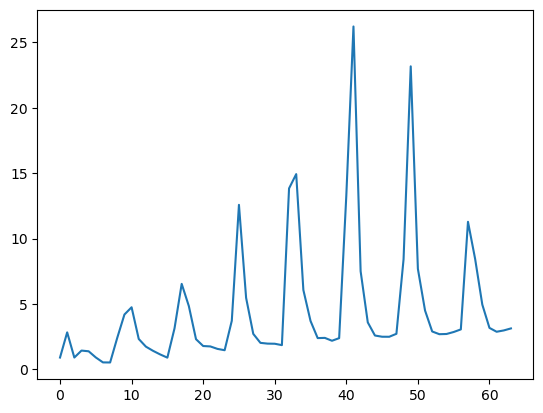

In [16]:
# screeplots

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))